In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=400
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

import glob,os
from collections import Counter, defaultdict, namedtuple
from Bio import SeqIO

base_path='/Users/evogytis/Documents/manuscripts/skeeters/data'

In [2]:
 
samples=set() ## will contain list of samples that not water and with assembled contigs
for f in glob.glob(os.path.join(base_path,'s3/contigs/CMS*/contigs.fasta')):
    cs=SeqIO.parse(f,format='fasta') ## load contigs
    s={s.id:s.seq for s in cs} ## convert sequences to dict
    if len(s)>0 and 'water' not in f.lower(): ## check there's any contigs at all and that contigs aren't water
        samples.add(os.path.basename(os.path.dirname(f))) ## add sample
        
virus_sample_combinations=set()
for line in open(os.path.join(base_path,'s3/contig_quality_concat/contig_calls_decontam.tsv'),'r'):
    l=line.strip('\n').split('\t')
    if l[0]=='sample':
        header={x: i for i,x in enumerate(l)}
    elif l[header['curated']]=='True':
        pol_group=int(float(l[header['poly_group']]))
        sample=l[header['sample']]
        virus_sample_combinations.add('%s|%s'%(pol_group,sample))

sample_virus_list={s.split('|')[1]: [w.split('|')[0] for w in virus_sample_combinations if w.split('|')[1]==s.split('|')[1]] for s in virus_sample_combinations}
for s in samples:
    if s not in sample_virus_list:
        sample_virus_list[s]=[]
        
virus_count={s:len(sample_virus_list[s]) for s in sample_virus_list}
sample_coinfections=Counter(virus_count)

for count in set(sample_coinfections.values()):
    S=[sample for sample in sample_coinfections if sample_coinfections[sample]==count]
    print('\nnumber of viruses: %d (in %d samples): %s'%(count,len(S),', '.join(S)))
    
out=open(os.path.join(base_path,'darkmatter/TableSX_coinfection.tsv'),'w')
out.write('sample\tpol_groups\n')

for sample in sample_virus_list:
    out.write('%s\t%s\n'%(sample,', '.join(sample_virus_list[sample])))
    
out.close()


number of viruses: 0 (in 9 samples): CMS002_025c_Rb_S142_L004, CMS001_014_Ra_S5, CMS001_055_Ra_S9, CMS002_025a_Rb_S140_L004, CMS002_007a_Rb_S118_L004, CMS002_025b_Rb_S141_L004, CMS002_050a_Rb_S5_L004, CMS002_025e_Rb_S144_L004, CMS002_004a_Rb_S117_L004

number of viruses: 1 (in 15 samples): CMS002_010a_Rb_S119_L004, CMS002_036a_Rb_S170_L004, CMS002_033a_Rb_S167_L004, CMS001_005_Ra_S3, CMS002_013a_Rb_S120_L004, CMS002_019a_Rb_S130_L004, CMS002_054a_Rb_S8_L004, CMS001_016_Ra_S6, CMS001_054_Ra_S11, CMS002_046b_Rb_S192_L004, CMS002_027a_Rb_S152_L004, CMS002_001a_Rb_S116_L004, CMS001_004_Ra_S2, CMS002_046a_Rb_S191_L004, CMS001_026_Ra_S18

number of viruses: 2 (in 28 samples): CMS002_047h_Rb_S1_L004, CMS002_017d_Rb_S125_L004, CMS001_029_Ra_S18, CMS002_027b_Rb_S153_L004, CMS001_009_Ra_S13, CMS002_034a_Rb_S168_L004, CMS002_047c_Rb_S195_L004, CMS002_018a_Rb_S128_L004, CMS002_039a_Rb_S173_L004, CMS002_018b_Rb_S129_L004, CMS001_030_Ra_S7, CMS002_028c_Rb_S156_L004, CMS001_023_Ra_S17, CMS002_044c_R

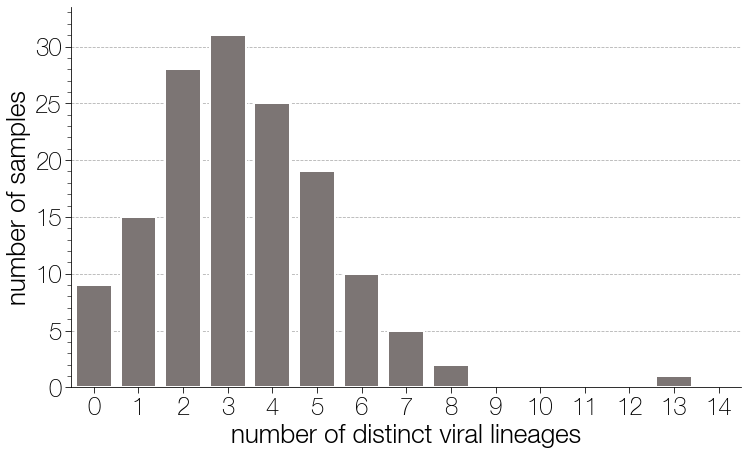

In [3]:
fig = plt.figure(figsize=(12,7),facecolor='w')
gs = gridspec.GridSpec(1,1)
ax=plt.subplot(gs[0],facecolor='w')

freqs=sample_coinfections.values()
bins=range(0,max(freqs)+3)
ax.hist(freqs,bins=bins,align='left',facecolor='#7C7574',edgecolor='w',rwidth=0.8,lw=2,zorder=10)

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.set_xticks(bins)
ax.set_xlim(-0.5,max(bins)-0.5)
ax.set_ylim(0,33.5)

ax.grid(axis='y',ls='--')
ax.tick_params(which='major',size=6,labelsize=24)
ax.tick_params(which='minor',size=4,labelsize=0)

ax.set_ylabel('number of samples',size=26)
ax.set_xlabel('number of distinct viral lineages',size=26)

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['left','bottom']]

plt.savefig('/Users/evogytis/Downloads/figS2_coinfection.pdf',dpi=300,bbox_inches='tight')
plt.savefig('/Users/evogytis/Downloads/figS2_coinfection.png',dpi=300,bbox_inches='tight')
plt.show()

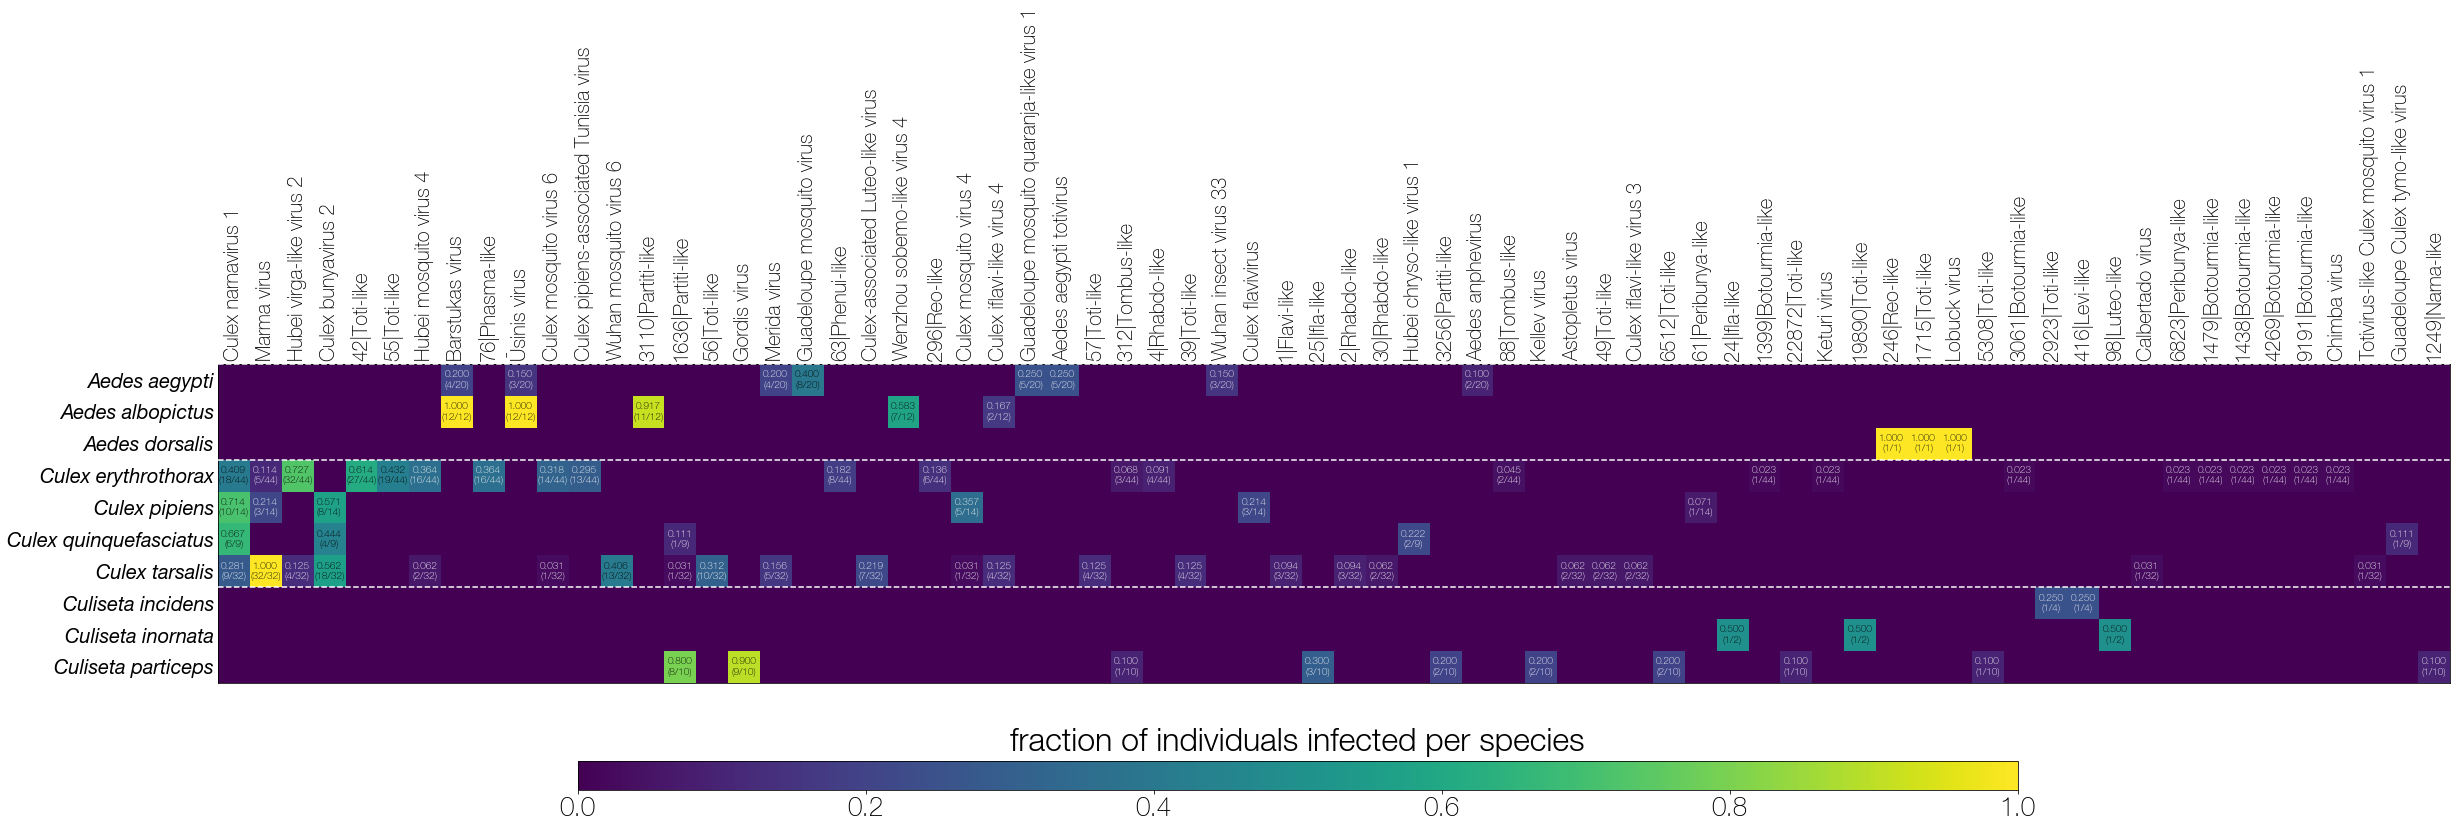

In [4]:
import json
import numpy as np
import pandas as pd


in_json=open(os.path.join(base_path,'darkmatter/virus.json'),'r')
virus=json.load(in_json)

metadata={}
for line in open(os.path.join(base_path,'metadata/CMS001_CMS002_MergedAnnotations.csv'),'r'):
    l=line.strip('\r\n').split(',')
    if 'NewIDseqName' in l[0]:
        header=l
    else:
        metadata[l[0]]={header[i]:l[i].strip(' ') for i in range(len(l))} ## load metadata

sample_species=lambda k: '%s %s'%(metadata[k]['ska_genus'],metadata[k]['ska_species'])
spp=[sample_species(s) for s in metadata]
species=set(spp)
spp_count=Counter(spp)

vir=set([k.split('|')[0] for k in virus_sample_combinations])

vir_species={v:{s:0 for s in species} for v in vir}

for c in virus_sample_combinations:
    v,s=c.split('|')
    vir_species[v][sample_species(s)]+=1
    
fig = plt.figure(figsize=(40,40),facecolor='w')
gs = gridspec.GridSpec(1,1)
ax=plt.subplot(gs[0],facecolor='w')

df=pd.DataFrame.from_dict(vir_species)

df = df[sorted(vir_species,key=lambda w: -sum(vir_species[w].values()))]
df = df.reindex(sorted(species,key=lambda w: (w,-spp_count[w])))

df = df.divide(spp_count,axis='rows')

heatmap = ax.matshow(df,cmap=mpl.cm.viridis)

for c,col in enumerate(df.columns):
    for r,row in enumerate(df.index):
        count=vir_species[col][row]
        if count>0:
            total=spp_count[row]
            frac=count/total
            
            fc='k'
            if frac<0.4:
                fc='w'
            ax.text(c,r,'%.03f\n(%s/%s)'%(frac,count,total),color=fc,va='center',ha='center')
        
store_genus=None
for s,S in enumerate(sorted(species,key=lambda w: (w,-spp_count[w]))):
    if store_genus!=S.split(' ')[0]:
        ax.axhline(s-0.5,color='w',ls='--',zorder=100)
    store_genus=S.split(' ')[0]
    
ax.set_yticks(range(len(spp_count)))
ax.set_yticklabels(sorted(species,key=lambda w: (w,-spp_count[w])),style='italic')

ax.xaxis.tick_top()
ax.set_xticks(range(len(vir_species)))
ax.set_xticklabels([virus[V]['provisional_name'] if 'provisional_name' in virus[V] else virus[V]['name'] for V in sorted(vir_species,key=lambda w: -sum(vir_species[w].values()))],rotation=90)

ax.tick_params(size=0,labelsize=20)

ax.set_aspect(1)

axcb = fig.add_axes([0.25, 0.41, 0.5, 0.01], frame_on=False)
cb = mpl.colorbar.ColorbarBase(axcb,cmap=mpl.cm.viridis,orientation='horizontal',alpha=1.0,drawedges=False)

axcb.xaxis.set_label_position('top')
axcb.set_xlabel('fraction of individuals infected per species',size=32)
axcb.xaxis.labelpad=10
axcb.tick_params(labelsize=26)

plt.show()